# Importation des librairies

In [1]:

import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import joblib
import zipfile
#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies_nb_usagers.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [4]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int64  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  int64  
 7   atm             447136 non-null  int64  
 8   col             447136 non-null  int64  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  int64  
 13  prof            447136 non-null  int64  
 14  plan            447136 non-null  int64  
 15  surf            447136 non-null  int64  
 16  infra           447136 non-null  int64  
 17  situ           

# Séparation en train et test

Suppression des colonnes qui ne serviront pas pour la modélisation

In [5]:
df = df.drop(['an', 'jour', 'grav_rec', 'date', 'dep', 'nb_usagers'], axis = 1)

Séparation des données de la cible

In [6]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
1    0.412733
4    0.403430
3    0.156550
2    0.027287
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chque modalité de la cible dans les jeux d'entraînement et de test.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
1    0.412733
4    0.403430
3    0.156549
2    0.027288
Name: proportion, dtype: float64
grav
1    0.412733
4    0.403430
3    0.156552
2    0.027285
Name: proportion, dtype: float64


In [8]:
X_train.shape

(335352, 36)

# Random Forest

### Selection des variables

In [9]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

In [10]:
print("Train acuracy :", np.round(rf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.9 %
Test acuracy :  67.4 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,38363,18,936,6820
2,401,156,1588,905
3,2485,157,7103,7755
4,11637,62,3679,29719



Rapport de classification :
               precision    recall  f1-score   support

           1       0.73      0.83      0.77     46137
           2       0.40      0.05      0.09      3050
           3       0.53      0.41      0.46     17500
           4       0.66      0.66      0.66     45097

    accuracy                           0.67    111784
   macro avg       0.58      0.49      0.50    111784
weighted avg       0.66      0.67      0.66    111784



Calcul de l'importance de chaque variable

In [11]:
importances_rf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(38)

,importance
feature,
lat,0.105
long,0.101
age_usager,0.100
heure,0.068
mois,0.057
eq_ceinture,0.051
nb_usagers_gr,0.045
place_rec,0.042
col,0.040


Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [12]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_rf), 1):
    liste_var = importances_rf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    rf_2 = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = rf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_rf = pd.DataFrame(dico)
y_pred_tableau_rf = y_pred_tableau_rf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_rf.head(5)

,nombre_variable,scores
33,34,0.674578
31,32,0.673415
32,33,0.673245
29,30,0.673218
30,31,0.672887


In [13]:
nb_variable_rf = y_pred_tableau_rf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_rf, 'variables')

La meilleur accuracy est obtenue avec 34.0 variables


In [14]:
meilleurs_variables_rf = importances_rf.index[0 : int(nb_variable_rf)]
meilleurs_variables_rf

Index(['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'nb_usagers_gr', 'place_rec', 'col', 'catv', 'obsm', 'catr',
       'eq_casque', 'manv', 'lum', 'motor', 'sexe', 'agg', 'obs', 'infra',
       'weekend', 'prox_pt_choc', 'jour_chome', 'circ', 'surf', 'int', 'prof',
       'situ', 'eq_indetermine', 'plan', 'atm', 'eq_gants', 'eq_airbag',
       'eq_autre'],
      dtype='object', name='feature')

In [15]:
liste_var = importances_rf.index[0 : int(nb_variable_rf)]
X_train_rf = X_train[liste_var]
X_test_rf = X_test[liste_var]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

In [16]:
print("Train acuracy :", np.round(rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.89 %
Test acuracy :  67.46 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,38463,16,906,6752
2,396,170,1569,915
3,2496,156,6958,7890
4,11643,60,3578,29816



Rapport de classification :
               precision    recall  f1-score   support

           1       0.73      0.83      0.78     46137
           2       0.42      0.06      0.10      3050
           3       0.53      0.40      0.46     17500
           4       0.66      0.66      0.66     45097

    accuracy                           0.67    111784
   macro avg       0.59      0.49      0.50    111784
weighted avg       0.66      0.67      0.66    111784



### Hyperparamétrage

In [17]:
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'nb_usagers_gr', 'place_rec', 'col', 'catv', 'obsm', 'catr',
       'eq_casque', 'manv', 'lum', 'motor', 'sexe', 'agg', 'obs', 'infra',
       'weekend', 'prox_pt_choc', 'jour_chome', 'circ', 'surf', 'int', 'prof',
       'situ', 'eq_indetermine', 'plan', 'atm', 'eq_gants', 'eq_airbag',
       'eq_autre']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

##### Avec class_weight = None

In [18]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20, None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}     

In [19]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.646112
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.645796
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.646002
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.645850
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.645850
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.668301
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.668301
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.664385
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.664385
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.664385

[108 rows x 2 columns]


In [20]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.6748640303922151


In [21]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 89.23 %
Test acuracy :  67.76 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,38754,2,715,6666
2,407,95,1578,970
3,2437,64,6834,8165
4,11699,13,3320,30065



Rapport de classification :
               precision    recall  f1-score   support

           1       0.73      0.84      0.78     46137
           2       0.55      0.03      0.06      3050
           3       0.55      0.39      0.46     17500
           4       0.66      0.67      0.66     45097

    accuracy                           0.68    111784
   macro avg       0.62      0.48      0.49    111784
weighted avg       0.67      0.68      0.66    111784



Recherche du meilleur max_depth

In [48]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [16],
             'min_samples_split' : [20],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}        

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [49]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.471387200432968


In [50]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 73.54 %
Test acuracy :  67.07 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,40064,1,495,5577
2,521,59,1468,1002
3,2892,30,6036,8542
4,13561,6,2711,28819



Rapport de classification :
               precision    recall  f1-score   support

           1       0.70      0.87      0.78     46137
           2       0.61      0.02      0.04      3050
           3       0.56      0.34      0.43     17500
           4       0.66      0.64      0.65     45097

    accuracy                           0.67    111784
   macro avg       0.63      0.47      0.47    111784
weighted avg       0.66      0.67      0.65    111784



##### Avec class_weight = 'balanced'

In [22]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20, None],
            'min_samples_split' : [2, 10, 20],
            'min_samples_leaf' : [1, 10, 20],
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}    

In [23]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': 'balanced...         0.581810
1    {'bootstrap': False, 'class_weight': 'balanced...         0.581422
2    {'bootstrap': False, 'class_weight': 'balanced...         0.581216
3    {'bootstrap': False, 'class_weight': 'balanced...         0.580915
4    {'bootstrap': False, 'class_weight': 'balanced...         0.580915
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': 'balanced'...         0.637584
104  {'bootstrap': True, 'class_weight': 'balanced'...         0.637584
105  {'bootstrap': True, 'class_weight': 'balanced'...         0.620956
106  {'bootstrap': True, 'class_weight': 'balanced'...         0.620956
107  {'bootstrap': True, 'class_weight': 'balanced'...         0.620956

[108 rows x 2 columns]


In [24]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.6696724706832871


In [25]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.89 %
Test acuracy :  67.33 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,38791,25,902,6419
2,415,193,1514,928
3,2570,188,6714,8028
4,12029,76,3424,29568



Rapport de classification :
               precision    recall  f1-score   support

           1       0.72      0.84      0.78     46137
           2       0.40      0.06      0.11      3050
           3       0.53      0.38      0.45     17500
           4       0.66      0.66      0.66     45097

    accuracy                           0.67    111784
   macro avg       0.58      0.49      0.50    111784
weighted avg       0.66      0.67      0.66    111784



Recherche du meilleur max_depth

In [51]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['entropy'],
            'max_depth' : [14],
            'min_samples_split' : [2],
            'min_samples_leaf' : [1],
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}   

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [52]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.5131380768451668


In [53]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 68.69 %
Test acuracy :  62.71 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,39567,904,2394,3272
2,274,1297,1184,295
3,2195,2849,9127,3329
4,14308,1602,9081,20106



Rapport de classification :
               precision    recall  f1-score   support

           1       0.70      0.86      0.77     46137
           2       0.19      0.43      0.27      3050
           3       0.42      0.52      0.46     17500
           4       0.74      0.45      0.56     45097

    accuracy                           0.63    111784
   macro avg       0.52      0.56      0.52    111784
weighted avg       0.66      0.63      0.62    111784



##### Recherche du meilleur class_weight

In [26]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20, None],
            'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{1: 1, 2: 4, 3: 1, 4: 1}]} 

In [27]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': {1: 1, 2:...         0.637614
1    {'bootstrap': False, 'class_weight': {1: 1, 2:...         0.637739
2    {'bootstrap': False, 'class_weight': {1: 1, 2:...         0.637971
3    {'bootstrap': False, 'class_weight': {1: 1, 2:...         0.637623
4    {'bootstrap': False, 'class_weight': {1: 1, 2:...         0.637623
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': {1: 1, 2: ...         0.662122
104  {'bootstrap': True, 'class_weight': {1: 1, 2: ...         0.662122
105  {'bootstrap': True, 'class_weight': {1: 1, 2: ...         0.655890
106  {'bootstrap': True, 'class_weight': {1: 1, 2: ...         0.655890
107  {'bootstrap': True, 'class_weight': {1: 1, 2: ...         0.655890

[108 rows x 2 columns]


In [28]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': {1: 1, 2: 4, 3: 1, 4: 1}, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.6729854035542809


In [29]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 90.4 %
Test acuracy :  67.52 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,38813,70,661,6593
2,393,435,1288,934
3,2479,565,6261,8195
4,11819,190,3124,29964



Rapport de classification :
               precision    recall  f1-score   support

           1       0.73      0.84      0.78     46137
           2       0.35      0.14      0.20      3050
           3       0.55      0.36      0.43     17500
           4       0.66      0.66      0.66     45097

    accuracy                           0.68    111784
   macro avg       0.57      0.50      0.52    111784
weighted avg       0.66      0.68      0.66    111784



Recherche du meilleur max_depth

In [57]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini'],
            'max_depth' : [14],
            'min_samples_split' : [10],
            'min_samples_leaf' : [1],
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{1: 1, 2: 4, 3: 1, 4: 1}]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [58]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': {1: 1, 2: 4, 3: 1, 4: 1}, 'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.5034818238442927


In [59]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 69.85 %
Test acuracy :  65.72 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,40360,120,327,5330
2,531,761,762,996
3,3084,1314,4226,8876
4,14507,453,2020,28117



Rapport de classification :
               precision    recall  f1-score   support

           1       0.69      0.87      0.77     46137
           2       0.29      0.25      0.27      3050
           3       0.58      0.24      0.34     17500
           4       0.65      0.62      0.64     45097

    accuracy                           0.66    111784
   macro avg       0.55      0.50      0.50    111784
weighted avg       0.64      0.66      0.64    111784



# Meilleur modèle

In [9]:
# Variables retenues lors de l'entraînement du modèle brut
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'nb_usagers_gr', 'place_rec', 'col', 'catv', 'obsm', 'catr',
       'eq_casque', 'manv', 'lum', 'motor', 'sexe', 'agg', 'obs', 'infra',
       'weekend', 'prox_pt_choc', 'jour_chome', 'circ', 'surf', 'int', 'prof',
       'situ', 'eq_indetermine', 'plan', 'atm', 'eq_gants', 'eq_airbag',
       'eq_autre']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

In [10]:
best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = 'balanced', 
                                    criterion = 'entropy', 
                                    max_depth = 13, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 65.99 %
Test acuracy :  61.67 %

Matrice de confusion :


Classes prédites,1,2,3,4
Classes réelles,,,,
1,39779,1115,2337,2906
2,279,1462,1040,269
3,2249,3373,8732,3146
4,15016,2029,9088,18964



Rapport de classification :
               precision    recall  f1-score   support

           1       0.69      0.86      0.77     46137
           2       0.18      0.48      0.27      3050
           3       0.41      0.50      0.45     17500
           4       0.75      0.42      0.54     45097

    accuracy                           0.62    111784
   macro avg       0.51      0.57      0.51    111784
weighted avg       0.66      0.62      0.61    111784



# Réentrainement avec changement de l'ordre des modalités de 'grav' pour l'affichage streamlit

In [11]:
y_train

135492    4
61030     4
97417     4
464936    3
256701    4
         ..
181495    3
453088    3
164103    4
172847    2
463162    1
Name: grav, Length: 335352, dtype: int64

In [12]:
# Modification de l'odre des modalités de 'grav' : 0 - indemenes, 1 - blessés légers, 2 - blessés hospitalisés, 3 - tués
y_train = y_train.replace([1, 2, 3, 4], ['ind', 'tue', 'bh', 'bl'])
y_train = y_train.replace(['ind', 'tue', 'bh', 'bl'], [0, 3, 2, 1])

y_test = y_test.replace([1, 2, 3, 4], ['ind', 'tue', 'bh', 'bl'])
y_test = y_test.replace(['ind', 'tue', 'bh', 'bl'], [0, 3, 2, 1])

In [13]:
y_train

135492    1
61030     1
97417     1
464936    2
256701    1
         ..
181495    2
453088    2
164103    1
172847    3
463162    0
Name: grav, Length: 335352, dtype: int64

In [14]:
# Variables retenues lors de l'entraînement du modèle brut
liste_var_rf = ['lat', 'long', 'age_usager', 'heure', 'mois', 'eq_ceinture',
       'nb_usagers_gr', 'place_rec', 'col', 'catv', 'obsm', 'catr',
       'eq_casque', 'manv', 'lum', 'motor', 'sexe', 'agg', 'obs', 'infra',
       'weekend', 'prox_pt_choc', 'jour_chome', 'circ', 'surf', 'int', 'prof',
       'situ', 'eq_indetermine', 'plan', 'atm', 'eq_gants', 'eq_airbag',
       'eq_autre']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

In [15]:
best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = 'balanced', 
                                    criterion = 'entropy', 
                                    max_depth = 13, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 65.94 %
Test acuracy :  61.58 %

Matrice de confusion :


Classes prédites,0,1,2,3
Classes réelles,,,,
0,39797,2909,2355,1076
1,15014,18746,9356,1981
2,2250,3064,8855,3331
3,282,261,1074,1433



Rapport de classification :
               precision    recall  f1-score   support

           0       0.69      0.86      0.77     46137
           1       0.75      0.42      0.54     45097
           2       0.41      0.51      0.45     17500
           3       0.18      0.47      0.26      3050

    accuracy                           0.62    111784
   macro avg       0.51      0.56      0.51    111784
weighted avg       0.66      0.62      0.61    111784



In [16]:
joblib.dump(best_model, "../../../data/saved_models/RandomForest_4classes_nb_usagers_gr.joblib")

['../../../data/saved_models/RandomForest_4classes_nb_usagers_gr.joblib']

In [17]:
fich = conf['local_data_path'] + "/saved_models/RandomForest_4classes_nb_usagers_gr.joblib"
fich_zip = conf['local_data_path'] + "/saved_models/RandomForest_4classes_nb_usagers_gr.zip"
myZip = zipfile.ZipFile(fich_zip, 'w', zipfile.ZIP_DEFLATED)
myZip.write(fich)
myZip.close()

In [18]:
score_train = best_model.score(X_train_rf, y_train)
score_test = best_model.score(X_test_rf, y_test)
print(f"Le score sur le jeu d'entraînement est de {score_train}, et de {score_test} sur le jeu de test.")

Le score sur le jeu d'entraînement est de 0.6593966936234166, et de 0.6157500178916482 sur le jeu de test.


                precision    recall  f1-score       support
Indemnes         0.694017  0.862583  0.769173   46137.00000
Blessés légers   0.750440  0.415682  0.535011   45097.00000
Blessés graves   0.409196  0.506000  0.452478   17500.00000
Tués             0.183225  0.469836  0.263637    3050.00000
accuracy         0.615750  0.615750  0.615750       0.61575
macro avg        0.509219  0.563525  0.505075  111784.00000
weighted avg     0.658254  0.615750  0.611333  111784.00000


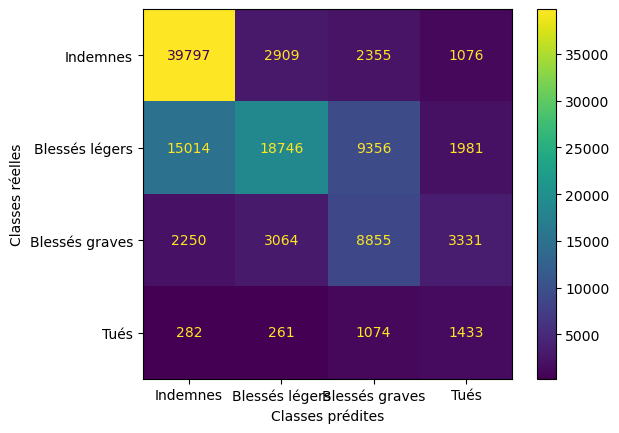

In [19]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay.from_estimator(
       best_model,
       X_test_rf,
       y_test,
       display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],
       values_format = 'd'
   )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig(conf['local_data_path'] + 'img/rf_4classes_nb_usagers_gr_confusion_matrix' + '.png')


cr= classification_report(y_test, y_test_pred,
target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'],
output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv(conf['local_data_path'] + 'img/rf_4classes_nb_usagers_gr_report' + '.csv')